In [132]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [133]:
# 1.set stocks tickets
choice = 1

ticket_1 = ['ARM', 'CART', 'VIK', 'RDDT', 'ALAB', 'RBRK', 'CRWV', 'CRCL']
tickers_2 = ['ARM', 'CART', 'VIK', 'RDDT', 'ALAB', 'RBRK']

if choice == 1:
    tickers = ticket_1
elif choice == 2:
    tickers = tickers_2
    
n_assets = len(tickers)



In [134]:
# 2.set date
start_date = '2023-01-01'
end_date = '2025-11-23'

In [135]:
# 3.download the data
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
data.head()

[*********************100%***********************]  8 of 8 completed


Ticker,ALAB,ARM,CART,CRCL,CRWV,RBRK,RDDT,VIK
Date,,,,,,,,
2023-09-14,NaN,63.590000,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-15,NaN,60.750000,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-18,NaN,58.000000,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-19,NaN,55.169998,33.700001,NaN,NaN,NaN,NaN,NaN
2023-09-20,NaN,52.910000,30.100000,NaN,NaN,NaN,NaN,NaN


In [136]:
# 4.drop Nan value
data = data.dropna()
print(f"successfully get {len(data)} transaction days。")

successfully get 119 transaction days。


In [137]:
# 5.calculate daily return using pct_change
returns = data.pct_change().dropna()
returns

Ticker,ALAB,ARM,CART,CRCL,CRWV,RBRK,RDDT,VIK
Date,,,,,,,,
2025-06-06,0.000441,0.027480,-0.012327,0.294004,0.037838,-0.006696,0.080631,0.018155
2025-06-09,0.017631,0.041319,0.005474,0.070102,0.156535,-0.048616,-0.031000,0.001845
2025-06-10,-0.009637,0.014573,-0.037892,-0.081041,-0.044417,-0.060118,-0.003744,-0.002660
2025-06-11,0.033676,-0.001778,-0.000226,0.106600,-0.033570,0.014963,-0.017593,-0.028513
2025-06-12,-0.002116,-0.012537,-0.002037,-0.090956,-0.004876,-0.001350,0.010171,0.007812
...,...,...,...,...,...,...,...,...
2025-11-17,-0.020438,0.003506,-0.013155,-0.064721,-0.026241,-0.025996,-0.029797,-0.034564
2025-11-18,-0.013226,-0.030087,0.017773,0.000131,-0.005708,-0.012771,-0.009917,0.017639
2025-11-19,0.017847,0.006983,0.004851,-0.089817,0.000267,0.018605,0.011255,0.050455


In [138]:
# 6.Calculate Key Matrices (Mapping to Handout 1)
# 6.1 Expected Return Vector mu (Annualized)
# We assume 252 trading days in a year
mu_daily = returns.mean()
mu_annual = mu_daily * 252
mu_annual

Ticker
ALAB    1.350540
ARM     0.157729
CART   -0.216157
CRCL    0.448367
CRWV   -0.896643
RBRK   -0.678772
RDDT    1.261417
VIK     0.649449
dtype: float64

In [139]:
# 6.2 Covariance Matrix Sigma (Annualized)
Sigma_daily = returns.cov()
Sigma_annual = Sigma_daily * 252
Sigma_annual

Ticker,ALAB,ARM,CART,CRCL,CRWV,RBRK,RDDT,VIK
Ticker,,,,,,,,
ALAB,0.820959,0.118802,0.027706,0.219609,0.186941,0.167513,0.204203,0.034704
ARM,0.118802,0.249240,0.009361,0.115370,0.149557,0.018390,0.060647,0.030497
CART,0.027706,0.009361,0.163325,0.027358,0.085333,0.005702,0.017574,0.009872
CRCL,0.219609,0.115370,0.027358,1.671388,0.324060,0.157219,0.179230,0.075652
CRWV,0.186941,0.149557,0.085333,0.324060,0.902316,0.029665,0.072921,0.035992
RBRK,0.167513,0.018390,0.005702,0.157219,0.029665,0.308144,0.034623,0.036702
RDDT,0.204203,0.060647,0.017574,0.179230,0.072921,0.034623,0.427331,0.042841
VIK,0.034704,0.030497,0.009872,0.075652,0.035992,0.036702,0.042841,0.074967


In [140]:
# 7. optimization Model Setup

# Objective Function
# min -t*mu'x + 0.5*x'Sigma*x
def objective_function(weights, mu, Sigma, t):
    # Expected Return term (Negative for minimization)
    term1 = -t * np.dot(weights, mu)
    # Variance term (Risk)
    term2 = 0.5 * np.dot(weights.T, np.dot(Sigma, weights))
    return term1 + term2

# Constraints
# 7.1. Budget Constraint: sum(x) = 1
def constraint_sum(weights):
    return np.sum(weights) - 1

# 7.2. Bound Constraints: x >= 0 (No short selling)
# set max_weight = 0.30
max_weight = 0.30
bounds = tuple((0, max_weight) for _ in range(n_assets))

# Constraint dictionary format for scipy
constraints = ({'type': 'eq', 'fun': constraint_sum})

In [141]:
# 8. Tracing the Efficient Frontier
# We scan different risk tolerance parameters 't' from 0 to 2.0
# t=0 corresponds to the Global Minimum Variance Portfolio
t_values = np.linspace(0, 2, 50) 

# 2025 NOV risk_free rate
rf = 0.04


frontier_returns = []
frontier_volatility = []
sharpe_ratios = []
all_weights = []

print("Running Parametric Quadratic Programming optimization...")

for t in t_values:
    # Initial guess (Equal weights)
    init_guess = n_assets * [1. / n_assets,]
    
    # Arguments for the objective function
    args = (mu_annual, Sigma_annual, t)
    
    # Run Optimizer SLSQP
    result = minimize(objective_function, init_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        # Extract optimal weights
        w = result.x
        all_weights.append(w)
        
        # Calculate annualized metrics for this portfolio
        # mu_p = mu'x
        ret = np.dot(w, mu_annual)
        # sigma_p^2 = x'Sigma x => volatility is sqrt
        vol = np.sqrt(np.dot(w.T, np.dot(Sigma_annual, w)))
        
        frontier_returns.append(ret)
        frontier_volatility.append(vol)
        
        # Calculate Sharpe Ratio
        # SR = (mu_p - rf) / sigma_p
        sr = (ret - rf) / vol
        sharpe_ratios.append(sr)



Running Parametric Quadratic Programming optimization...


In [142]:
# 9. Selecting the Optimal Portfolio
# Find the index with the maximum Sharpe Ratio
max_sr_idx = np.argmax(sharpe_ratios)

# Retrieve data for the optimal portfolio
optimal_weights = all_weights[max_sr_idx]
opt_ret = frontier_returns[max_sr_idx]
opt_vol = frontier_volatility[max_sr_idx]
best_t = t_values[max_sr_idx]

print("\n" + "="*40)
print(f"Optimization Complete! (Based on Max Sharpe, t={best_t:.2f})")
print("="*40)
print(f"Expected Annual Return:    {opt_ret:.2%}")
print(f"Expected Annual Volatility:{opt_vol:.2%}")
print(f"Maximum Sharpe Ratio:      {sharpe_ratios[max_sr_idx]:.2f}")
print("-" * 40)
print("Optimal Weights Allocation:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"  {ticker}: {weight:.2%}")
print("="*40)


Optimization Complete! (Based on Max Sharpe, t=0.20)
Expected Annual Return:    99.42%
Expected Annual Volatility:43.00%
Maximum Sharpe Ratio:      2.22
----------------------------------------
Optimal Weights Allocation:
  ARM: 30.00%
  CART: 10.00%
  VIK: 0.00%
  RDDT: 0.00%
  ALAB: 0.00%
  RBRK: 0.00%
  CRWV: 30.00%
  CRCL: 30.00%


C:\Users\15223\AppData\Local\Temp\ipykernel_89388\3254527274.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (asset_vols[i], asset_rets[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)


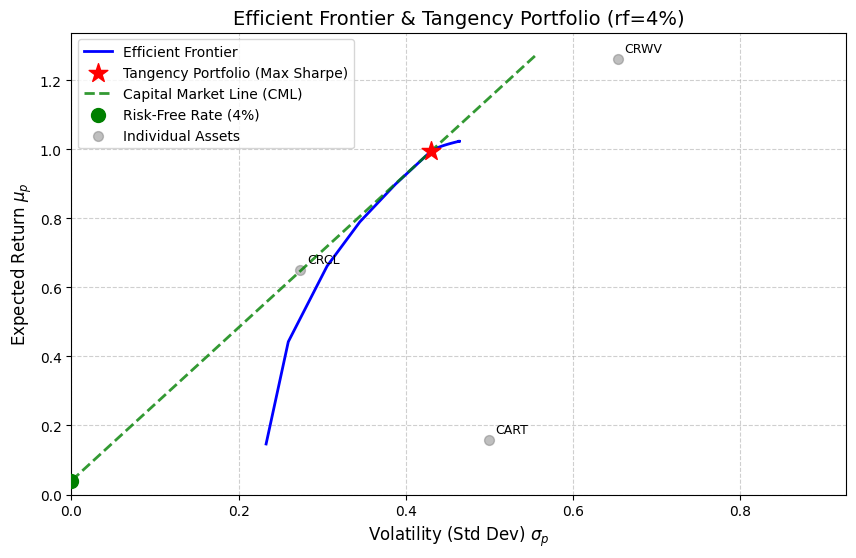

In [143]:
# 10. Visualization (Efficient Frontier with CML)
plt.figure(figsize=(10, 6))

# 1. Plot Efficient Frontier
plt.plot(frontier_volatility, frontier_returns, 'b-', linewidth=2, label='Efficient Frontier')

# 2. Plot Optimal Portfolio (Tangency Point)
plt.scatter(opt_vol, opt_ret, c='red', s=200, marker='*', label='Tangency Portfolio (Max Sharpe)', zorder=5)

# 3. Plot Capital Market Line (CML)
# Line Equation: y = rf + Sharpe * x
max_sharpe = (opt_ret - rf) / opt_vol

# Generate points for CML
x_cml = np.linspace(0, max(frontier_volatility) * 1.2, 100)
y_cml = rf + max_sharpe * x_cml

plt.plot(x_cml, y_cml, 'g--', linewidth=2, alpha=0.8, label='Capital Market Line (CML)')

# 4. Plot Risk-Free Rate Intercept
plt.scatter(0, rf, c='green', s=100, marker='o', label=f'Risk-Free Rate ({rf:.0%})', zorder=5)

# 5. Plot Individual Assets
asset_vols = np.sqrt(np.diag(Sigma_annual))
asset_rets = mu_annual
plt.scatter(asset_vols, asset_rets, c='gray', s=50, alpha=0.5, label='Individual Assets')

# Annotate Asset Names
for i, txt in enumerate(tickers):
    plt.annotate(txt, (asset_vols[i], asset_rets[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)

# Plot Configuration
plt.title(f'Efficient Frontier & Tangency Portfolio (rf={rf:.0%})', fontsize=14)
plt.xlabel(r'Volatility (Std Dev) $\sigma_p$', fontsize=12)
plt.ylabel(r'Expected Return $\mu_p$', fontsize=12)

# Ensure axes start from 0 to show the risk-free intercept clearly
plt.xlim(0, max(frontier_volatility) * 2)
plt.ylim(0, max(y_cml) * 1.05)

plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Save and Show
plt.savefig('frontier.png', dpi=300)
plt.show()